In [1]:
import h5py, os, pickle
from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

from ecog.utils import bands
from cv_paper_plots.style import (subject_colors, letter_fontstyle,
                                  ticklabel_fontstyle, subject_labels)

import scipy as sp
from cv_paper_plots import xfreq_analysis as xfa
from cv_paper_plots.xfreq_analysis import good_examples_and_channels
from cv_paper_plots.broadband import (forward_bl, invert_bl, new_ch_idx, get_pcs, flip,
                                      baseline_mean_std, plot_PC1s)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/home/jesse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [2]:
folder = os.path.join(os.environ['HOME'],'Development/data/ecog/AA_ff/')
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
files = ['EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'EC9_blocks_15_39_46_49_53_60_63_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP31_blocks_1_2_4_6_9_21_63_65_67_69_71_78_82_83_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP33_blocks_1_5_30_CV_AA_ff_align_window_-0.5_to_0.79_none.h5']
freqs = bands.chang_lab['cfs']

In [3]:
subject_idx = 0
subject = subjects[subject_idx]

In [4]:
baselines = dict()
with h5py.File(os.path.join(folder, files[subject_idx]), 'r') as f:
    block_labels = f['block'].value
    for key, value in f.items():
        if ('block' in key) and ('band' in key):
            items = key.split('_')
            block, band = int(items[2]), int(items[4])
            baselines[(block, band)] = np.squeeze(value.value).astype('float32')
    good_examples, good_channels = good_examples_and_channels(f['X0'].value)
    vsmc = np.concatenate([f['anatomy']['preCG'].value, f['anatomy']['postCG'].value])
    vsmc_electrodes = np.zeros(256)
    vsmc_electrodes[vsmc] = 1
    tokens = f['tokens'].value.astype('str').tolist()

    good_examples = sorted(np.nonzero(good_examples)[0].tolist())

    good_channels = sorted(np.nonzero(vsmc_electrodes * good_channels)[0].tolist())
    n_trials, n_channels, n_time = f['X0'].shape
    print(len(good_examples), len(good_channels))
    X = np.zeros((40, len(good_examples), len(good_channels), n_time), dtype='float32')
    block_labels = block_labels[good_examples]
    for ii in range(40):
        X[ii] = f['X{}'.format(ii)][good_examples][:, good_channels]
    labels = f['y'][good_examples]

2572 85


KeyboardInterrupt: 

In [16]:
bl_mean, bl_std = baseline_mean_std(block_labels, good_channels, baselines)
cvs = sorted(set(labels))

# Remove P1

In [17]:
bl_type = 'bl_zscore'
X, bl_type_means = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)

In [18]:
rng = np.random.RandomState(20180917)

pcs = np.full((2, len(cvs), len(good_channels), 3, 40), np.nan)
evs = np.full((2, len(cvs), len(good_channels), 3), np.nan)

means = np.full((2, len(cvs), len(good_channels), 40), np.nan)

pcs_s = np.full((2, len(cvs), len(good_channels), 3, 40), np.nan)
evs_s = np.full((2, len(cvs), len(good_channels), 3), np.nan)

for ch in range(len(good_channels)):
    for ii, cv in enumerate(cvs):
        d = X[:, np.where(labels == cv)[0]][:, :, ch]
        print(ch, ii, d.shape)
        d = d.reshape(40, -1).T
        for jj, center_pca in enumerate([True, False]):
            dp = d
            dp_s = np.zeros_like(dp)
            for nn in range(dp.shape[1]):
                dp_s[:, nn] = rng.permutation(dp[:, nn])
            (w, v), m = get_pcs(dp, center_pca)
            pcs[jj, ii, ch] = v[:, ::-1].T
            evs[jj, ii, ch] = w[::-1]
            means[jj, ii, ch] = m
            (w_s, v_s), _ = get_pcs(dp_s, center_pca)
            pcs_s[jj, ii, ch] = v_s[:, ::-1].T
            evs_s[jj, ii, ch] = w_s[::-1]

pcs = flip(pcs)
pcs_s = flip(pcs_s)

0 0 (40, 45, 258)
0 1 (40, 46, 258)
0 2 (40, 34, 258)
0 3 (40, 44, 258)
0 4 (40, 44, 258)
0 5 (40, 48, 258)
0 6 (40, 46, 258)
0 7 (40, 45, 258)
0 8 (40, 44, 258)
0 9 (40, 44, 258)
0 10 (40, 43, 258)
0 11 (40, 44, 258)
0 12 (40, 49, 258)
0 13 (40, 50, 258)
0 14 (40, 46, 258)
0 15 (40, 48, 258)
0 16 (40, 45, 258)
0 17 (40, 51, 258)
0 18 (40, 44, 258)
0 19 (40, 46, 258)
0 20 (40, 47, 258)
0 21 (40, 47, 258)
0 22 (40, 47, 258)
0 23 (40, 37, 258)
0 24 (40, 44, 258)
0 25 (40, 43, 258)
0 26 (40, 53, 258)
0 27 (40, 46, 258)
0 28 (40, 46, 258)
0 29 (40, 38, 258)
0 30 (40, 48, 258)
0 31 (40, 46, 258)
0 32 (40, 46, 258)
0 33 (40, 44, 258)
0 34 (40, 47, 258)
0 35 (40, 47, 258)
0 36 (40, 48, 258)
0 37 (40, 48, 258)
0 38 (40, 45, 258)
0 39 (40, 47, 258)
0 40 (40, 46, 258)
0 41 (40, 47, 258)
0 42 (40, 10, 258)
0 43 (40, 44, 258)
0 44 (40, 47, 258)
0 45 (40, 47, 258)
0 46 (40, 46, 258)
0 47 (40, 43, 258)
0 48 (40, 46, 258)
0 49 (40, 47, 258)
0 50 (40, 43, 258)
0 51 (40, 46, 258)
0 52 (40, 47, 258)
0 5

7 37 (40, 48, 258)
7 38 (40, 45, 258)
7 39 (40, 47, 258)
7 40 (40, 46, 258)
7 41 (40, 47, 258)
7 42 (40, 10, 258)
7 43 (40, 44, 258)
7 44 (40, 47, 258)
7 45 (40, 47, 258)
7 46 (40, 46, 258)
7 47 (40, 43, 258)
7 48 (40, 46, 258)
7 49 (40, 47, 258)
7 50 (40, 43, 258)
7 51 (40, 46, 258)
7 52 (40, 47, 258)
7 53 (40, 55, 258)
7 54 (40, 44, 258)
7 55 (40, 46, 258)
7 56 (40, 48, 258)
8 0 (40, 45, 258)
8 1 (40, 46, 258)
8 2 (40, 34, 258)
8 3 (40, 44, 258)
8 4 (40, 44, 258)
8 5 (40, 48, 258)
8 6 (40, 46, 258)
8 7 (40, 45, 258)
8 8 (40, 44, 258)
8 9 (40, 44, 258)
8 10 (40, 43, 258)
8 11 (40, 44, 258)
8 12 (40, 49, 258)
8 13 (40, 50, 258)
8 14 (40, 46, 258)
8 15 (40, 48, 258)
8 16 (40, 45, 258)
8 17 (40, 51, 258)
8 18 (40, 44, 258)
8 19 (40, 46, 258)
8 20 (40, 47, 258)
8 21 (40, 47, 258)
8 22 (40, 47, 258)
8 23 (40, 37, 258)
8 24 (40, 44, 258)
8 25 (40, 43, 258)
8 26 (40, 53, 258)
8 27 (40, 46, 258)
8 28 (40, 46, 258)
8 29 (40, 38, 258)
8 30 (40, 48, 258)
8 31 (40, 46, 258)
8 32 (40, 46, 258)
8 3

15 1 (40, 46, 258)
15 2 (40, 34, 258)
15 3 (40, 44, 258)
15 4 (40, 44, 258)
15 5 (40, 48, 258)
15 6 (40, 46, 258)
15 7 (40, 45, 258)
15 8 (40, 44, 258)
15 9 (40, 44, 258)
15 10 (40, 43, 258)
15 11 (40, 44, 258)
15 12 (40, 49, 258)
15 13 (40, 50, 258)
15 14 (40, 46, 258)
15 15 (40, 48, 258)
15 16 (40, 45, 258)
15 17 (40, 51, 258)
15 18 (40, 44, 258)
15 19 (40, 46, 258)
15 20 (40, 47, 258)
15 21 (40, 47, 258)
15 22 (40, 47, 258)
15 23 (40, 37, 258)
15 24 (40, 44, 258)
15 25 (40, 43, 258)
15 26 (40, 53, 258)
15 27 (40, 46, 258)
15 28 (40, 46, 258)
15 29 (40, 38, 258)
15 30 (40, 48, 258)
15 31 (40, 46, 258)
15 32 (40, 46, 258)
15 33 (40, 44, 258)
15 34 (40, 47, 258)
15 35 (40, 47, 258)
15 36 (40, 48, 258)
15 37 (40, 48, 258)
15 38 (40, 45, 258)
15 39 (40, 47, 258)
15 40 (40, 46, 258)
15 41 (40, 47, 258)
15 42 (40, 10, 258)
15 43 (40, 44, 258)
15 44 (40, 47, 258)
15 45 (40, 47, 258)
15 46 (40, 46, 258)
15 47 (40, 43, 258)
15 48 (40, 46, 258)
15 49 (40, 47, 258)
15 50 (40, 43, 258)
15 51 (40

22 16 (40, 45, 258)
22 17 (40, 51, 258)
22 18 (40, 44, 258)
22 19 (40, 46, 258)
22 20 (40, 47, 258)
22 21 (40, 47, 258)
22 22 (40, 47, 258)
22 23 (40, 37, 258)
22 24 (40, 44, 258)
22 25 (40, 43, 258)
22 26 (40, 53, 258)
22 27 (40, 46, 258)
22 28 (40, 46, 258)
22 29 (40, 38, 258)
22 30 (40, 48, 258)
22 31 (40, 46, 258)
22 32 (40, 46, 258)
22 33 (40, 44, 258)
22 34 (40, 47, 258)
22 35 (40, 47, 258)
22 36 (40, 48, 258)
22 37 (40, 48, 258)
22 38 (40, 45, 258)
22 39 (40, 47, 258)
22 40 (40, 46, 258)
22 41 (40, 47, 258)
22 42 (40, 10, 258)
22 43 (40, 44, 258)
22 44 (40, 47, 258)
22 45 (40, 47, 258)
22 46 (40, 46, 258)
22 47 (40, 43, 258)
22 48 (40, 46, 258)
22 49 (40, 47, 258)
22 50 (40, 43, 258)
22 51 (40, 46, 258)
22 52 (40, 47, 258)
22 53 (40, 55, 258)
22 54 (40, 44, 258)
22 55 (40, 46, 258)
22 56 (40, 48, 258)
23 0 (40, 45, 258)
23 1 (40, 46, 258)
23 2 (40, 34, 258)
23 3 (40, 44, 258)
23 4 (40, 44, 258)
23 5 (40, 48, 258)
23 6 (40, 46, 258)
23 7 (40, 45, 258)
23 8 (40, 44, 258)
23 9 (40,

29 31 (40, 46, 258)
29 32 (40, 46, 258)
29 33 (40, 44, 258)
29 34 (40, 47, 258)
29 35 (40, 47, 258)
29 36 (40, 48, 258)
29 37 (40, 48, 258)
29 38 (40, 45, 258)
29 39 (40, 47, 258)
29 40 (40, 46, 258)
29 41 (40, 47, 258)
29 42 (40, 10, 258)
29 43 (40, 44, 258)
29 44 (40, 47, 258)
29 45 (40, 47, 258)
29 46 (40, 46, 258)
29 47 (40, 43, 258)
29 48 (40, 46, 258)
29 49 (40, 47, 258)
29 50 (40, 43, 258)
29 51 (40, 46, 258)
29 52 (40, 47, 258)
29 53 (40, 55, 258)
29 54 (40, 44, 258)
29 55 (40, 46, 258)
29 56 (40, 48, 258)
30 0 (40, 45, 258)
30 1 (40, 46, 258)
30 2 (40, 34, 258)
30 3 (40, 44, 258)
30 4 (40, 44, 258)
30 5 (40, 48, 258)
30 6 (40, 46, 258)
30 7 (40, 45, 258)
30 8 (40, 44, 258)
30 9 (40, 44, 258)
30 10 (40, 43, 258)
30 11 (40, 44, 258)
30 12 (40, 49, 258)
30 13 (40, 50, 258)
30 14 (40, 46, 258)
30 15 (40, 48, 258)
30 16 (40, 45, 258)
30 17 (40, 51, 258)
30 18 (40, 44, 258)
30 19 (40, 46, 258)
30 20 (40, 47, 258)
30 21 (40, 47, 258)
30 22 (40, 47, 258)
30 23 (40, 37, 258)
30 24 (40,

36 46 (40, 46, 258)
36 47 (40, 43, 258)
36 48 (40, 46, 258)
36 49 (40, 47, 258)
36 50 (40, 43, 258)
36 51 (40, 46, 258)
36 52 (40, 47, 258)
36 53 (40, 55, 258)
36 54 (40, 44, 258)
36 55 (40, 46, 258)
36 56 (40, 48, 258)
37 0 (40, 45, 258)
37 1 (40, 46, 258)
37 2 (40, 34, 258)
37 3 (40, 44, 258)
37 4 (40, 44, 258)
37 5 (40, 48, 258)
37 6 (40, 46, 258)
37 7 (40, 45, 258)
37 8 (40, 44, 258)
37 9 (40, 44, 258)
37 10 (40, 43, 258)
37 11 (40, 44, 258)
37 12 (40, 49, 258)
37 13 (40, 50, 258)
37 14 (40, 46, 258)
37 15 (40, 48, 258)
37 16 (40, 45, 258)
37 17 (40, 51, 258)
37 18 (40, 44, 258)
37 19 (40, 46, 258)
37 20 (40, 47, 258)
37 21 (40, 47, 258)
37 22 (40, 47, 258)
37 23 (40, 37, 258)
37 24 (40, 44, 258)
37 25 (40, 43, 258)
37 26 (40, 53, 258)
37 27 (40, 46, 258)
37 28 (40, 46, 258)
37 29 (40, 38, 258)
37 30 (40, 48, 258)
37 31 (40, 46, 258)
37 32 (40, 46, 258)
37 33 (40, 44, 258)
37 34 (40, 47, 258)
37 35 (40, 47, 258)
37 36 (40, 48, 258)
37 37 (40, 48, 258)
37 38 (40, 45, 258)
37 39 (40,

44 4 (40, 44, 258)
44 5 (40, 48, 258)
44 6 (40, 46, 258)
44 7 (40, 45, 258)
44 8 (40, 44, 258)
44 9 (40, 44, 258)
44 10 (40, 43, 258)
44 11 (40, 44, 258)
44 12 (40, 49, 258)
44 13 (40, 50, 258)
44 14 (40, 46, 258)
44 15 (40, 48, 258)
44 16 (40, 45, 258)
44 17 (40, 51, 258)
44 18 (40, 44, 258)
44 19 (40, 46, 258)
44 20 (40, 47, 258)
44 21 (40, 47, 258)
44 22 (40, 47, 258)
44 23 (40, 37, 258)
44 24 (40, 44, 258)
44 25 (40, 43, 258)
44 26 (40, 53, 258)
44 27 (40, 46, 258)
44 28 (40, 46, 258)
44 29 (40, 38, 258)
44 30 (40, 48, 258)
44 31 (40, 46, 258)
44 32 (40, 46, 258)
44 33 (40, 44, 258)
44 34 (40, 47, 258)
44 35 (40, 47, 258)
44 36 (40, 48, 258)
44 37 (40, 48, 258)
44 38 (40, 45, 258)
44 39 (40, 47, 258)
44 40 (40, 46, 258)
44 41 (40, 47, 258)
44 42 (40, 10, 258)
44 43 (40, 44, 258)
44 44 (40, 47, 258)
44 45 (40, 47, 258)
44 46 (40, 46, 258)
44 47 (40, 43, 258)
44 48 (40, 46, 258)
44 49 (40, 47, 258)
44 50 (40, 43, 258)
44 51 (40, 46, 258)
44 52 (40, 47, 258)
44 53 (40, 55, 258)
44 54 

51 19 (40, 46, 258)
51 20 (40, 47, 258)
51 21 (40, 47, 258)
51 22 (40, 47, 258)
51 23 (40, 37, 258)
51 24 (40, 44, 258)
51 25 (40, 43, 258)
51 26 (40, 53, 258)
51 27 (40, 46, 258)
51 28 (40, 46, 258)
51 29 (40, 38, 258)
51 30 (40, 48, 258)
51 31 (40, 46, 258)
51 32 (40, 46, 258)
51 33 (40, 44, 258)
51 34 (40, 47, 258)
51 35 (40, 47, 258)
51 36 (40, 48, 258)
51 37 (40, 48, 258)
51 38 (40, 45, 258)
51 39 (40, 47, 258)
51 40 (40, 46, 258)
51 41 (40, 47, 258)
51 42 (40, 10, 258)
51 43 (40, 44, 258)
51 44 (40, 47, 258)
51 45 (40, 47, 258)
51 46 (40, 46, 258)
51 47 (40, 43, 258)
51 48 (40, 46, 258)
51 49 (40, 47, 258)
51 50 (40, 43, 258)
51 51 (40, 46, 258)
51 52 (40, 47, 258)
51 53 (40, 55, 258)
51 54 (40, 44, 258)
51 55 (40, 46, 258)
51 56 (40, 48, 258)
52 0 (40, 45, 258)
52 1 (40, 46, 258)
52 2 (40, 34, 258)
52 3 (40, 44, 258)
52 4 (40, 44, 258)
52 5 (40, 48, 258)
52 6 (40, 46, 258)
52 7 (40, 45, 258)
52 8 (40, 44, 258)
52 9 (40, 44, 258)
52 10 (40, 43, 258)
52 11 (40, 44, 258)
52 12 (40,

58 34 (40, 47, 258)
58 35 (40, 47, 258)
58 36 (40, 48, 258)
58 37 (40, 48, 258)
58 38 (40, 45, 258)
58 39 (40, 47, 258)
58 40 (40, 46, 258)
58 41 (40, 47, 258)
58 42 (40, 10, 258)
58 43 (40, 44, 258)
58 44 (40, 47, 258)
58 45 (40, 47, 258)
58 46 (40, 46, 258)
58 47 (40, 43, 258)
58 48 (40, 46, 258)
58 49 (40, 47, 258)
58 50 (40, 43, 258)
58 51 (40, 46, 258)
58 52 (40, 47, 258)
58 53 (40, 55, 258)
58 54 (40, 44, 258)
58 55 (40, 46, 258)
58 56 (40, 48, 258)
59 0 (40, 45, 258)
59 1 (40, 46, 258)
59 2 (40, 34, 258)
59 3 (40, 44, 258)
59 4 (40, 44, 258)
59 5 (40, 48, 258)
59 6 (40, 46, 258)
59 7 (40, 45, 258)
59 8 (40, 44, 258)
59 9 (40, 44, 258)
59 10 (40, 43, 258)
59 11 (40, 44, 258)
59 12 (40, 49, 258)
59 13 (40, 50, 258)
59 14 (40, 46, 258)
59 15 (40, 48, 258)
59 16 (40, 45, 258)
59 17 (40, 51, 258)
59 18 (40, 44, 258)
59 19 (40, 46, 258)
59 20 (40, 47, 258)
59 21 (40, 47, 258)
59 22 (40, 47, 258)
59 23 (40, 37, 258)
59 24 (40, 44, 258)
59 25 (40, 43, 258)
59 26 (40, 53, 258)
59 27 (40,

65 49 (40, 47, 258)
65 50 (40, 43, 258)
65 51 (40, 46, 258)
65 52 (40, 47, 258)
65 53 (40, 55, 258)
65 54 (40, 44, 258)
65 55 (40, 46, 258)
65 56 (40, 48, 258)
66 0 (40, 45, 258)
66 1 (40, 46, 258)
66 2 (40, 34, 258)
66 3 (40, 44, 258)
66 4 (40, 44, 258)
66 5 (40, 48, 258)
66 6 (40, 46, 258)
66 7 (40, 45, 258)
66 8 (40, 44, 258)
66 9 (40, 44, 258)
66 10 (40, 43, 258)
66 11 (40, 44, 258)
66 12 (40, 49, 258)
66 13 (40, 50, 258)
66 14 (40, 46, 258)
66 15 (40, 48, 258)
66 16 (40, 45, 258)
66 17 (40, 51, 258)
66 18 (40, 44, 258)
66 19 (40, 46, 258)
66 20 (40, 47, 258)
66 21 (40, 47, 258)
66 22 (40, 47, 258)
66 23 (40, 37, 258)
66 24 (40, 44, 258)
66 25 (40, 43, 258)
66 26 (40, 53, 258)
66 27 (40, 46, 258)
66 28 (40, 46, 258)
66 29 (40, 38, 258)
66 30 (40, 48, 258)
66 31 (40, 46, 258)
66 32 (40, 46, 258)
66 33 (40, 44, 258)
66 34 (40, 47, 258)
66 35 (40, 47, 258)
66 36 (40, 48, 258)
66 37 (40, 48, 258)
66 38 (40, 45, 258)
66 39 (40, 47, 258)
66 40 (40, 46, 258)
66 41 (40, 47, 258)
66 42 (40,

73 7 (40, 45, 258)
73 8 (40, 44, 258)
73 9 (40, 44, 258)
73 10 (40, 43, 258)
73 11 (40, 44, 258)
73 12 (40, 49, 258)
73 13 (40, 50, 258)
73 14 (40, 46, 258)
73 15 (40, 48, 258)
73 16 (40, 45, 258)
73 17 (40, 51, 258)
73 18 (40, 44, 258)
73 19 (40, 46, 258)
73 20 (40, 47, 258)
73 21 (40, 47, 258)
73 22 (40, 47, 258)
73 23 (40, 37, 258)
73 24 (40, 44, 258)
73 25 (40, 43, 258)
73 26 (40, 53, 258)
73 27 (40, 46, 258)
73 28 (40, 46, 258)
73 29 (40, 38, 258)
73 30 (40, 48, 258)
73 31 (40, 46, 258)
73 32 (40, 46, 258)
73 33 (40, 44, 258)
73 34 (40, 47, 258)
73 35 (40, 47, 258)
73 36 (40, 48, 258)
73 37 (40, 48, 258)
73 38 (40, 45, 258)
73 39 (40, 47, 258)
73 40 (40, 46, 258)
73 41 (40, 47, 258)
73 42 (40, 10, 258)
73 43 (40, 44, 258)
73 44 (40, 47, 258)
73 45 (40, 47, 258)
73 46 (40, 46, 258)
73 47 (40, 43, 258)
73 48 (40, 46, 258)
73 49 (40, 47, 258)
73 50 (40, 43, 258)
73 51 (40, 46, 258)
73 52 (40, 47, 258)
73 53 (40, 55, 258)
73 54 (40, 44, 258)
73 55 (40, 46, 258)
73 56 (40, 48, 258)
74 

80 22 (40, 47, 258)
80 23 (40, 37, 258)
80 24 (40, 44, 258)
80 25 (40, 43, 258)
80 26 (40, 53, 258)
80 27 (40, 46, 258)
80 28 (40, 46, 258)
80 29 (40, 38, 258)
80 30 (40, 48, 258)
80 31 (40, 46, 258)
80 32 (40, 46, 258)
80 33 (40, 44, 258)
80 34 (40, 47, 258)
80 35 (40, 47, 258)
80 36 (40, 48, 258)
80 37 (40, 48, 258)
80 38 (40, 45, 258)
80 39 (40, 47, 258)
80 40 (40, 46, 258)
80 41 (40, 47, 258)
80 42 (40, 10, 258)
80 43 (40, 44, 258)
80 44 (40, 47, 258)
80 45 (40, 47, 258)
80 46 (40, 46, 258)
80 47 (40, 43, 258)
80 48 (40, 46, 258)
80 49 (40, 47, 258)
80 50 (40, 43, 258)
80 51 (40, 46, 258)
80 52 (40, 47, 258)
80 53 (40, 55, 258)
80 54 (40, 44, 258)
80 55 (40, 46, 258)
80 56 (40, 48, 258)
81 0 (40, 45, 258)
81 1 (40, 46, 258)
81 2 (40, 34, 258)
81 3 (40, 44, 258)
81 4 (40, 44, 258)
81 5 (40, 48, 258)
81 6 (40, 46, 258)
81 7 (40, 45, 258)
81 8 (40, 44, 258)
81 9 (40, 44, 258)
81 10 (40, 43, 258)
81 11 (40, 44, 258)
81 12 (40, 49, 258)
81 13 (40, 50, 258)
81 14 (40, 46, 258)
81 15 (40,

In [ ]:
X = invert_bl(X, bl_type, bl_type_means, bl_mean, bl_std, block_labels)

In [19]:
np.savez('{}_pca_analysis_zscore_cv-ch'.format(subject), pcs=pcs, evs=evs,
         means=means, axes=['center_pca'])

In [4]:
d = np.load('{}_pca_analysis_zscore_cv-ch.npz'.format(subject))
pcs = d['pcs']
evs = d['evs']
means = d['means']

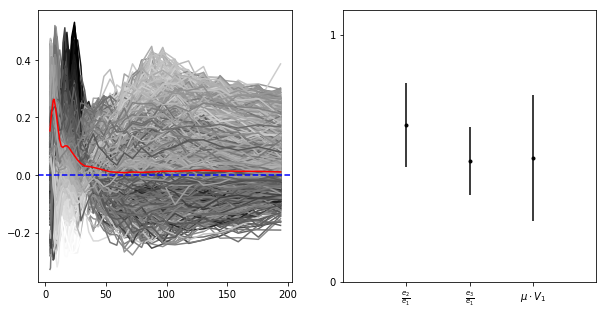

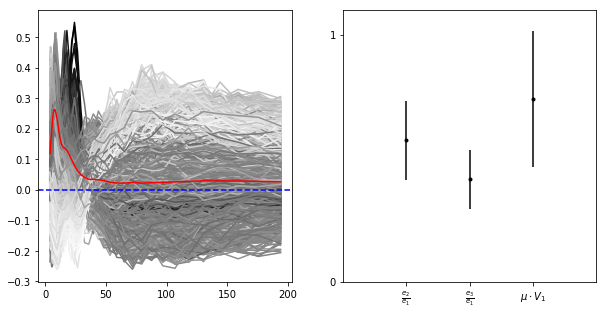

In [5]:
faxes = plt.subplots(1, 2, figsize=(10, 5))
plot_PC1s(pcs[0], evs[0], means[0], faxes=faxes)
faxes = plt.subplots(1, 2, figsize=(10, 5))
plot_PC1s(pcs[1], evs[1], means[1], faxes=faxes)

In [8]:
beta = bands.chang_lab['cfs'] >= bands.neuro['min_freqs'][2]
beta = np.where(np.logical_and(beta, bands.chang_lab['cfs'] <= bands.neuro['max_freqs'][3]))
hg = bands.chang_lab['cfs'] >= bands.neuro['min_freqs'][-1]
hg = np.where(np.logical_and(hg, bands.chang_lab['cfs'] <= bands.neuro['max_freqs'][-1]))

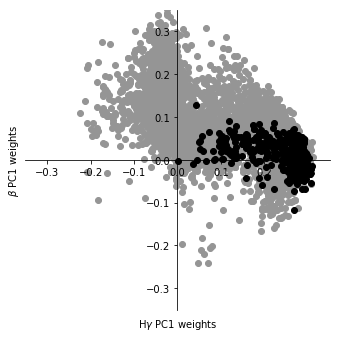

In [9]:
cv_channels = np.load(os.path.join(os.environ['HOME'], 'plots/xfreq/data',
                                  '{}_hg_power_cutoff.npz'.format(subject)))['cv_channels']
active = cv_channels.ravel().astype('float')

f, ax = plt.subplots(1, figsize=(5, 5))
bw = pcs[0, :, :, 0][:, :, beta].mean(axis=-1).ravel()
hgw = pcs[0, :, :, 0][:, :, hg].mean(axis=-1).ravel()
idxs = np.where(active == 0.)[0]
ax.scatter(hgw[idxs], bw[idxs], c=cm.Greys(.5))
idxs = np.where(active == 1.)[0]
ax.scatter(hgw[idxs], bw[idxs], c=cm.Greys(1.))
ax.set_xlabel(r'H$\gamma$ PC1 weights', labelpad=140)
ax.set_ylabel(r'$\beta$ PC1 weights', labelpad=125)
ax.set_xlim(-.35, .35)
ax.set_ylim(-.35, .35)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

f.tight_layout()
plt.savefig('/home/jesse/Downloads/{}_hg_vs_b_cv-ch.pdf'.format(subject))

In [13]:
def cluster_PC1s(pcs, n_clusters=2, faxes=None, title=False, ylabel=None):
    if pcs.ndim > 3:
        pcs = pcs.reshape(-1, 3, 40)
    if faxes is None:
        faxes = plt.subplots(n_clusters)
    f, axes = faxes
    beta_weights = (pcs[:, 0, 14:20]).sum(axis=-1)
    print(pcs.shape[0])
    beta_weights -= beta_weights.min()
    beta_weights /= beta_weights.max()
    model = KMeans(n_clusters=n_clusters)
    y = model.fit_predict(pcs[:, 0])
    print(pcs.shape)
    for ii, pc0 in enumerate(pcs[:, 0]):
        yi = y[ii]
        axes[yi].plot(freqs, pc0 ,c=cm.Greys(beta_weights[ii]), alpha=1.)
    for ii, ax in enumerate(axes):
        ax.plot(freqs, np.median(pcs[y == ii, 0], axis=0), c='r')
        ax.axhline(0, 0, 1, c='blue', ls='--')
    return y

4845
(4845, 3, 40)


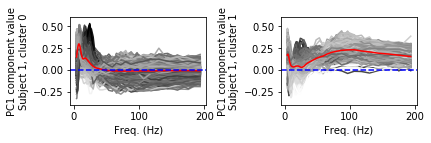

In [26]:
d = np.load('{}_pca_analysis_zscore_cv-ch.npz'.format(subject))
pcs = d['pcs']
n_clusters = 2
faxes = plt.subplots(1, n_clusters, figsize=(3*n_clusters, 2))
y = cluster_PC1s(pcs[0], n_clusters=n_clusters, faxes=faxes)
f, axes = faxes
for ii, ax in enumerate(axes.ravel()):
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.4, .6)
    ax.set_ylabel('PC1 component value\n{}, cluster {}'.format(subject_labels[subject], ii))
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s_cv-ch.pdf'.format(subject_labels[subject])))

In [15]:
max((active == y).mean(), (active == (1-y)).mean())

0.7568627450980392

In [16]:
oval = max((active == y).mean(), (active == (1-y)).mean())
n = 100000
vals = np.zeros(n)
for ii in range(n):
    yp = np.random.permutation(y)
    vals[ii] = max((active == yp).mean(), (active == (1-yp)).mean())

In [17]:
(vals >= oval).mean()

0.0

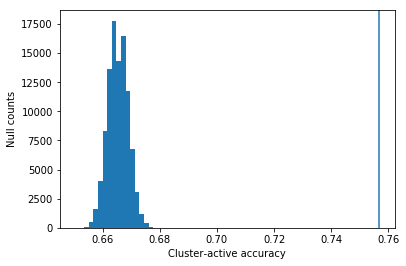

In [25]:
plt.hist(vals, bins=20)
plt.axvline(oval, 0, 1)
plt.xlabel('Cluster-active accuracy')
plt.ylabel('Null counts')
plt.savefig('/home/jesse/Downloads/null_cluster.pdf')

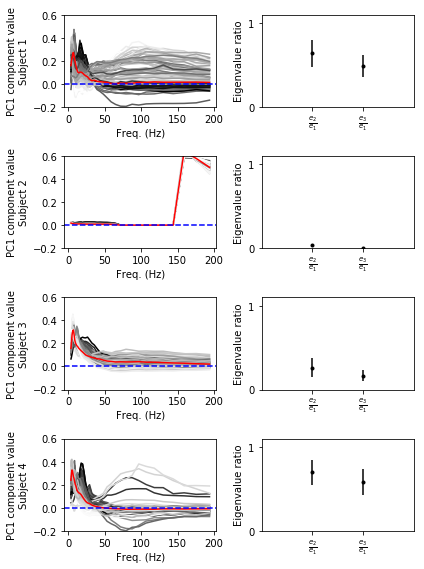

In [99]:
f, axes = plt.subplots(4, 2, figsize=(6, 8))
for ii, subject in enumerate(subjects):
    ax = axes[ii]
    d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
    pcs = d['pcs']
    evs = d['evs']
    #means = d['means']
    plot_PC0s(pcs[0], evs[0], None, faxes=(f, ax))
    ax[0].set_ylabel('PC1 component value\n{}'.format(subject_labels[subject]))
for ax in axes[:, 0]:
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.2, .6)
for ax in axes[:, 1]:
    ax.set_ylabel('Eigenvalue ratio')
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/PC1s.pdf'))